# Analyze NYC Crime Data from NYC OpenData 

Created by : Ankur Arya, March 2019

Complains reported to NYPD are available in NYC Open Data. Imported crime data set is inspected, cleaned for irrelevant features and erroneous values, and manipulated for meaningful information like comparing crimes in boroughs and neighborhoods on NYC.
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243/data 

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import requests
import re

import json
from pandas.io.json import json_normalize

import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import os
import glob
from pathlib import Path

## Importing and Compiling NYC Crime Data

In [2]:
#csv file downloaded from NYC open data is very big in size for github, hence the csv is split into two files and imported
#df_raw = pd.read_csv('NYPD_Complaint_Data_Current__Year_To_Date_.csv')

df_raw1 = pd.read_csv('NYPD_Complaint_Data_Current__Year_To_Date_split1.csv')
df_raw2 = pd.read_csv('NYPD_Complaint_Data_Current__Year_To_Date_split2.csv')
df_raw = pd.concat([df_raw1,df_raw2])
print ('shape of raw crime data imported : {}'.format(df_raw.shape))
df_raw.head()

shape of raw crime data imported : (464065, 36)


,Unnamed: 0,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,0,651421035,41.0,BRONX,11/28/2018,00:00:00,11/28/2018,00:01:00,COMPLETED,NaN,...,U,NaN,25-44,BLACK,M,NaN,NaN,NaN,NaN,NaN
1,1,149013323,14.0,MANHATTAN,12/31/2018,23:40:00,12/31/2018,23:50:00,COMPLETED,NaN,...,NaN,NaN,45-64,WHITE,F,987866.0,214721.0,40.756044,-73.986950,"(40.75604353500006, -73.98694954399997)"
2,2,642981531,73.0,BROOKLYN,12/31/2018,23:30:00,12/31/2018,23:40:00,COMPLETED,NaN,...,F,NaN,18-24,WHITE HISPANIC,F,1006995.0,185258.0,40.675146,-73.918003,"(40.67514616200003, -73.91800323399997)"
3,3,429685363,67.0,BROOKLYN,12/31/2018,23:20:00,12/31/2018,23:30:00,COMPLETED,NaN,...,M,NaN,25-44,BLACK,F,999584.0,169903.0,40.633016,-73.944756,"(40.63301598000004, -73.94475559899996)"
4,4,290330841,5.0,MANHATTAN,12/31/2018,23:15:00,12/31/2018,23:20:00,COMPLETED,NaN,...,U,NaN,25-44,WHITE,M,986164.0,202140.0,40.721512,-73.993096,"(40.72151233500005, -73.99309646799998)"


### Create a subset of crime data by random sampling

In [3]:
num_samples = 10000

df_crime = pd.DataFrame(columns = df_raw.columns)
for index in np.random.randint(0, len(df_raw), num_samples):
    df_crime = df_crime.append(pd.DataFrame(df_raw.iloc[index,:]).T, ignore_index=True)

# remove NAs in key features 
df_crime.dropna(subset=['BORO_NM','Latitude','Longitude'], inplace=True)

# fixing the index
df_crime.reset_index(drop=True, inplace=True)

# creating an index column which is helpful later in merge
df_crime.reset_index(drop=False, inplace=True) 
df_crime.head()

,index,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,0,785355746,18,MANHATTAN,10/20/2018,00:00:00,10/20/2018,08:00:00,COMPLETED,NaN,...,NaN,NaN,UNKNOWN,UNKNOWN,E,991193,218032,40.7651,-73.9749,"(40.76512939600008, -73.97493736299998)"
1,1,291754042,113,QUEENS,03/22/2018,23:00:00,03/22/2018,23:45:00,COMPLETED,NaN,...,M,NaN,UNKNOWN,UNKNOWN,E,1.04895e+06,191568,40.6923,-73.7667,"(40.692258391000045, -73.76668355899994)"
2,2,842830150,25,MANHATTAN,01/11/2018,14:00:00,01/11/2018,14:05:00,COMPLETED,NaN,...,M,NaN,UNKNOWN,UNKNOWN,E,1.00111e+06,231977,40.8034,-73.9391,"(40.803391359000045, -73.93910943199995)"
3,3,807060721,67,BROOKLYN,09/19/2018,08:40:00,09/19/2018,08:40:00,COMPLETED,NaN,...,NaN,NaN,UNKNOWN,UNKNOWN,E,1.0072e+06,178771,40.6573,-73.9173,"(40.657340254000076, -73.91727185199994)"
4,4,433616894,48,BRONX,09/02/2018,18:15:00,09/02/2018,18:27:00,COMPLETED,NaN,...,NaN,NaN,UNKNOWN,UNKNOWN,D,1.01653e+06,245903,40.8416,-73.8833,"(40.84157137500005, -73.88333376899999)"


In [4]:
df_crime['BORO_NM'].unique()

array(['MANHATTAN', 'QUEENS', 'BROOKLYN', 'BRONX', 'STATEN ISLAND'],
      dtype=object)

### Visualize the crime data in folium map

In [5]:
# create function to help rendering folium maps in notebook
def view_map(m):
    from IPython.display import IFrame

    m.save('index.html')
    return IFrame('index.html', width='100%', height='950px')

In [6]:
# Get geographical coordinates of NY city
address = 'New York, NY'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.7308619 -73.9871558


In [7]:
# Create base map layer of NY city
copyright_st = '<a> Ankur Arya 2019</a>'\
                ' | Data Courtesy:<a href="https://opendata.cityofnewyork.us/"> NYC OpenData </a>'
map_crime = folium.Figure(width=900, height=950)
map_crime = folium.Map(location=[latitude, longitude],zoom_start=11, attr = copyright_st).add_to(map_crime)

In [8]:
# Add crime data based choropleth layer to the map
for index, row in df_crime.iterrows():
    folium.CircleMarker([float(row['Latitude']), float(row['Longitude'])],
                        radius=3,
                        color='red',
                        fill=True,
                        fill_color='red',
                        fill_opacity=0.8,
                        line_opacity=0
                       ).add_to(map_crime)
view_map(map_crime)

### Grouping the crime data to nearest neighborhood centroid

In [9]:
# Import NYC neighborhood centroid list
df_nyhood = pd.read_csv('NHoodNameCentroids.csv')
df_nyhood['Borough'] = list(map(str.upper, df_nyhood['Borough']))
df_nyhood.head()

,the_geom,OBJECTID,Name,Stacked,AnnoLine1,AnnoLine2,AnnoLine3,AnnoAngle,Borough
0,POINT (-73.8472005205491 40.89470517661004),1,Wakefield,1,Wakefield,NaN,NaN,0,BRONX
1,POINT (-73.82993910812405 40.87429419303015),2,Co-op City,2,Co-op,City,NaN,0,BRONX
2,POINT (-73.82780644716419 40.88755567735082),3,Eastchester,1,Eastchester,NaN,NaN,0,BRONX
3,POINT (-73.90564259591689 40.895437426903875),4,Fieldston,1,Fieldston,NaN,NaN,0,BRONX
4,POINT (-73.91258546108577 40.89083449389134),5,Riverdale,1,Riverdale,NaN,NaN,0,BRONX


In [10]:
# Extract latitude and longitude from above dataframe for ease to making maps and calculating distance
nyhood_coord_list = df_nyhood['the_geom']
nycentroid_list = []
for index in np.arange(0, len(nyhood_coord_list)):
    row = re.findall('-?\d+'+'.\d+', nyhood_coord_list[index])
    nycentroid_list.append([float(row[0]),float(row[1])])
print ('checking first few elements of NY neighborhood centroids:\n', nycentroid_list[0:5])

checking first few elements of NY neighborhood centroids:
 [[-73.8472005205491, 40.89470517661004], [-73.82993910812405, 40.87429419303015], [-73.82780644716419, 40.88755567735082], [-73.90564259591689, 40.895437426903875], [-73.91258546108577, 40.89083449389134]]


In [11]:
# function returns index of min distance between 'point' and points in array_centroid

def find_nearest(point, array_centroids):
    #point is a array of x,y coordinate like [x,y]
    #array_centroids is array of point coordinates [[x1,y1],[x2,y2], ... [xn,yn]]
#   point = list(map(float,point))
    array_distance = np.zeros(len(array_centroids))
    for i in np.arange(0,len(array_centroids)):
        x_distance = point[0] - array_centroids[i][0]
        y_distance = point[1] - array_centroids[i][1]
        array_distance[i] = np.sqrt(np.square(x_distance)+np.square(y_distance))
#   print ("array_distance:\n",array_distance)
    index = array_distance.argmin()
    return index

In [12]:
#
# This code classifies each crime entry to closest neighborhood based on Euclidean distance 
#

df_crime_classified = pd.DataFrame(columns={'index','hood_name','borough_name','hood_longitude','hood_latitude'})

for index, row in df_crime.iterrows():
    
    # create a copy of neighborhood centroid coordinates 
    # ** copy of list by indices, so parent does not change ** 
    centroids = nycentroid_list[::]
     
    # get coordinates of the crime site
    point = [float(row['Longitude']),float(row['Latitude'])]
    
    # get index of nearest NYC neighborhood centroid
    nearest_index = find_nearest(point, centroids)
    print (df_nyhood['Borough'].values[nearest_index], ",", row['BORO_NM'])
    
    # if the boroughs of crime site and centroid are not same, repeat ... 
    while (df_nyhood.loc[nearest_index]['Borough'] != row['BORO_NM'] ):
        # first set this centroid coord to 0,0 so its very far ...
        # 0,0 is in Gulf of Guinea in the Atlantic Ocean, south of Ghana (Googled it)
        centroids[nearest_index] = [0,0] 
        print ("Boroughs are not same; trying again ...")
        nearest_index = find_nearest(point, centroids)
    print (df_nyhood['Borough'][nearest_index], ",", row['BORO_NM'])
 
    #creating a key feature to join the tables later  <<< make sure index  is correct and unique !
    index_crime = row['index']
    hood_name = df_nyhood.loc[nearest_index]['Name']
    boro_name = df_nyhood.loc[nearest_index]['Borough']
    hood_long = centroids[nearest_index][0]
    hood_lat = centroids[nearest_index][1]    

    df_crime_classified = df_crime_classified.append({'index':int(index_crime),'hood_name':hood_name,\
                          'borough_name':boro_name,'hood_longitude':hood_long,'hood_latitude':hood_lat},ignore_index=True)

# combine the nearest neighbor into the dataframe and output into csv
df_crime = df_crime.join(df_crime_classified, on='index',rsuffix='_r')
df_crime.to_csv('nyc_crime_classified.csv')



MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUE

STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANH

QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MA

BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , BRONX
Boroughs are not same; trying again ...
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN


MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN

BRONX , MANHATTAN
Boroughs are not same; trying again ...
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN


QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOK

BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , QUEENS
Boroughs are not same; trying again ...
Boroughs are not same; trying again ...
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN ,

BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , B

BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , MANHATTAN
Boroughs are not same; trying again ...
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN


BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROO

QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , 

MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , B

MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN


BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , B

MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN


BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS ,

STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , 

QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS ,

BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
MANH

QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHAT

QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MA

BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRON

QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN

MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANH

BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOK

BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS


BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , MANHATTAN
Boroughs are not same; trying again ...
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX


BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN

MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , QUEENS
Boroughs are not same; trying again ...
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BR

BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , 

BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTA

MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROO

QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , MANHATTAN
Boroughs are not same; trying again ...
MANHATTAN , MANHATTAN
QUEENS ,

QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN


MANHATTAN , QUEENS
Boroughs are not same; trying again ...
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
B

BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX


MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN

MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN

MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , MANHATTAN
Boroug

MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUE

BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BRONX , BRONX
BRONX , BRONX
STATEN ISLAND , STATEN ISLAND
STATEN ISLAND , STATEN ISLAND
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX , BRONX
MANHATTAN , MANHATTAN
MANHATTAN , MANHATTAN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
QUEENS , QUEENS
QUEENS , QUEENS
BRONX , BRONX
BRONX , BRONX
QUEENS , QUEENS
QUEENS , QUEENS
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BROOKLYN , BROOKLYN
BRONX , BRONX
BRONX 

In [13]:
#check the merged data
print ('check the merged data post nearest neighbor join :', df_crime.shape)
df_crime.head()

check the merged data post nearest neighbor join : (9991, 41)


,index,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,hood_latitude,index_r,borough_name,hood_name,hood_longitude
0,0,785355746,18,MANHATTAN,10/20/2018,00:00:00,10/20/2018,08:00:00,COMPLETED,NaN,...,991193,218032,40.7651,-73.9749,"(40.76512939600008, -73.97493736299998)",40.760280,0,MANHATTAN,Sutton Place,-73.963556
1,1,291754042,113,QUEENS,03/22/2018,23:00:00,03/22/2018,23:45:00,COMPLETED,NaN,...,1.04895e+06,191568,40.6923,-73.7667,"(40.692258391000045, -73.76668355899994)",40.694445,1,QUEENS,St. Albans,-73.758676
2,2,842830150,25,MANHATTAN,01/11/2018,14:00:00,01/11/2018,14:05:00,COMPLETED,NaN,...,1.00111e+06,231977,40.8034,-73.9391,"(40.803391359000045, -73.93910943199995)",40.792249,2,MANHATTAN,East Harlem,-73.944182
3,3,807060721,67,BROOKLYN,09/19/2018,08:40:00,09/19/2018,08:40:00,COMPLETED,NaN,...,1.0072e+06,178771,40.6573,-73.9173,"(40.657340254000076, -73.91727185199994)",40.652117,3,BROOKLYN,Remsen Village,-73.916653
4,4,433616894,48,BRONX,09/02/2018,18:15:00,09/02/2018,18:27:00,COMPLETED,NaN,...,1.01653e+06,245903,40.8416,-73.8833,"(40.84157137500005, -73.88333376899999)",40.842696,4,BRONX,East Tremont,-73.887356


### Visualize the classification of crime sites to nearest neighborhood centroids 

In [15]:
# define function which chooses color of folium marker based on entry index
stepcolor = ['red','orange','yellow','green','cyan','blue','magenta']
def get_color(index):
    global df_crime
    global df_nyhood
    hood_name = df_crime['hood_name'][index]
    crime_hood_name = np.array(df_nyhood['Name'])
    return np.where(crime_hood_name == hood_name)[0][0]

In [16]:
# Create base map layer of NY city
copyright_st = '<a> Ankur Arya 2019</a>'\
                ' | Data Courtesy:<a href="https://opendata.cityofnewyork.us/"> NYC OpenData </a>'
map_crime = folium.Figure(width=800, height=850)
map_crime = folium.Map(location=[latitude, longitude],zoom_start=11, attr = copyright_st).add_to(map_crime)

In [17]:
# Add the neighborhood centroids in the map
for index in np.arange(0,len(nycentroid_list)):
    folium.CircleMarker(
    [nycentroid_list[index][1],nycentroid_list[index][0]],
    radius=5, 
    color='black',
    fill=True,
    fill_color=stepcolor[index%7],
    fill_opacity=0.8,
    ).add_to(map_crime)

#folium.LayerControl(collapsed=False).add_to(h_ny)
view_map(map_crime)

In [18]:
# Add crime sites in the map
for index, row in df_crime.iterrows():
    color_index = get_color(index)
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=1,
                        color=stepcolor[color_index%7],
                        fill=True,
                        fill_color=stepcolor[color_index%7],
                        fill_opacity=0.8,
                        line_opacity=0
                       ).add_to(map_crime)

#folium.LayerControl(collapsed=False).add_to(h_ny)
view_map(map_crime)

In [19]:
# Add the neighborhood centroids equi distant partition layer
json_file =r'NYC_Neighborhood_Centroid_Derivative.geojson'
folium.GeoJson(
    json_file,
    name='Neighborhood Areas',
    style_function=lambda feature: {
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0
    }
).add_to(map_crime)

view_map(map_crime)

In [20]:
# save the map
map_crime.save('nyc_crimes_classified.html')

## Descriptive Statistics

In [21]:
# There are not many numerical variables for direct tabulating summary. 
df_crime.describe()

,index,hood_latitude,hood_longitude
count,9991.000000,9991.000000,9991.000000
mean,4995.000000,40.736424,-73.925500
std,2884.297604,0.083197,0.076775
min,0.000000,40.505334,-74.246569
25%,2497.500000,40.675040,-73.968367
50%,4995.000000,40.736075,-73.929113
75%,7492.500000,40.815099,-73.882821
max,9990.000000,40.908543,-73.708847


Quantiles of reported crime per neighborhood :
 0.00      1.00
0.25      9.00
0.50     22.00
0.75     51.25
0.94     97.56
1.00    255.00
Name: CMPLNT_NUM, dtype: float64


Text(0,0.5,'Frequency')

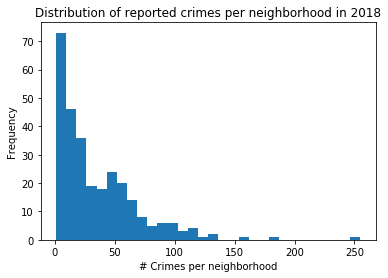

In [22]:
# With appropriate summarization like below, data is visualized better. Check out plots in cells below.

df_nta = df_crime[['CMPLNT_NUM','hood_name']]
df_nta = df_nta.groupby(['hood_name']).count()
df_nta.reset_index(drop = False, inplace = True)
print ('Quantiles of reported crime per neighborhood :\n' ,df_nta['CMPLNT_NUM'].quantile([0, 0.25,0.5, 0.75, 0.94,1]))

df_nta['CMPLNT_NUM'].plot(kind='hist', bins=30)
plt.title('Distribution of reported crimes per neighborhood in 2018')
plt.xlabel('# Crimes per neighborhood')
plt.ylabel('Frequency')

## Plot Bar Chart showing number of crimes by borough

In [23]:
df_boro_summ = df_crime.groupby(['borough_name']).agg({'CMPLNT_NUM' : 'sum'})
sum = df_boro_summ.sum()
df_boro_summ = df_boro_summ['CMPLNT_NUM'].apply(lambda x: 100 * x / sum)


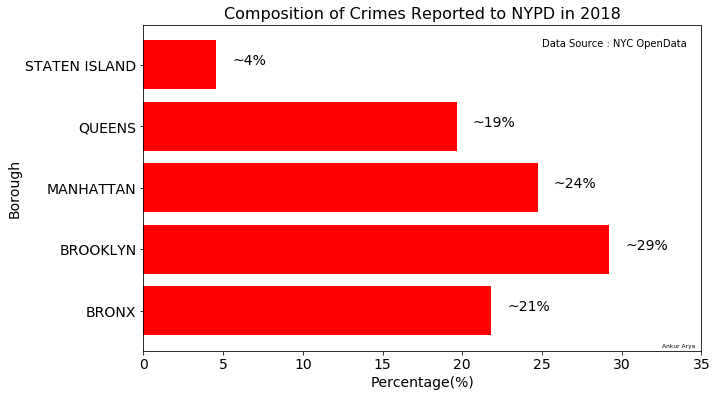

In [24]:
box_colors=['red','orange','yellow','green','cyan','blue','magenta']
df_boro_summ.plot(kind = 'barh', color = box_colors, width = 0.8, fontsize = 14, legend = None, figsize=(10,6),xlim=(0,35))
plt.xlabel('Percentage(%)',fontsize = 14)
plt.ylabel('Borough',fontsize = 14)
plt.title('Composition of Crimes Reported to NYPD in 2018',fontsize = 16)
plt.annotate('Data Source : NYC OpenData', xy=(25,4.3), fontsize=10)
plt.annotate('Ankur Arya', xy=(32.5,-0.6),fontsize=6)

index=0
for i, row in df_boro_summ.iterrows():
    display_text = '~'+ str(int(row['CMPLNT_NUM'])) + '%'
    plt.annotate(display_text, xy=(row['CMPLNT_NUM']+1,index), fontsize=14)
    index+=1


## Plot Bar Chart Showing top 10 Crimes by Borough

In [25]:
df_crime_summ = df_crime.groupby(['OFNS_DESC','borough_name']).count()
df_crime_summ = df_crime_summ.reset_index(drop=False)
df_crime_summ = df_crime_summ.pivot(index = 'OFNS_DESC', columns = 'borough_name', values = 'CMPLNT_NUM'  )
df_crime_summ.fillna(0, inplace=True)
df_crime_summ['Total'] = df_crime_summ.sum(axis=1)
df_crime_summ.sort_values(by = ['Total'], ascending = False, inplace=True)
df_crime_summ.head()

borough_name,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Total
OFNS_DESC,,,,,,
PETIT LARCENY,344.0,512.0,621.0,346.0,78.0,1901.0
HARRASSMENT 2,350.0,462.0,311.0,338.0,99.0,1560.0
ASSAULT 3 & RELATED OFFENSES,327.0,317.0,236.0,234.0,51.0,1165.0
CRIMINAL MISCHIEF & RELATED OF,214.0,326.0,199.0,201.0,47.0,987.0
GRAND LARCENY,136.0,234.0,373.0,183.0,21.0,947.0


In [26]:
df_crime_summ = df_crime_summ.apply(lambda x: 100*x / df_crime_summ['Total'])
df_crime_summ.drop(columns={'Total'},inplace=True)
df_top_10_crime_sum = df_crime_summ.head(10)

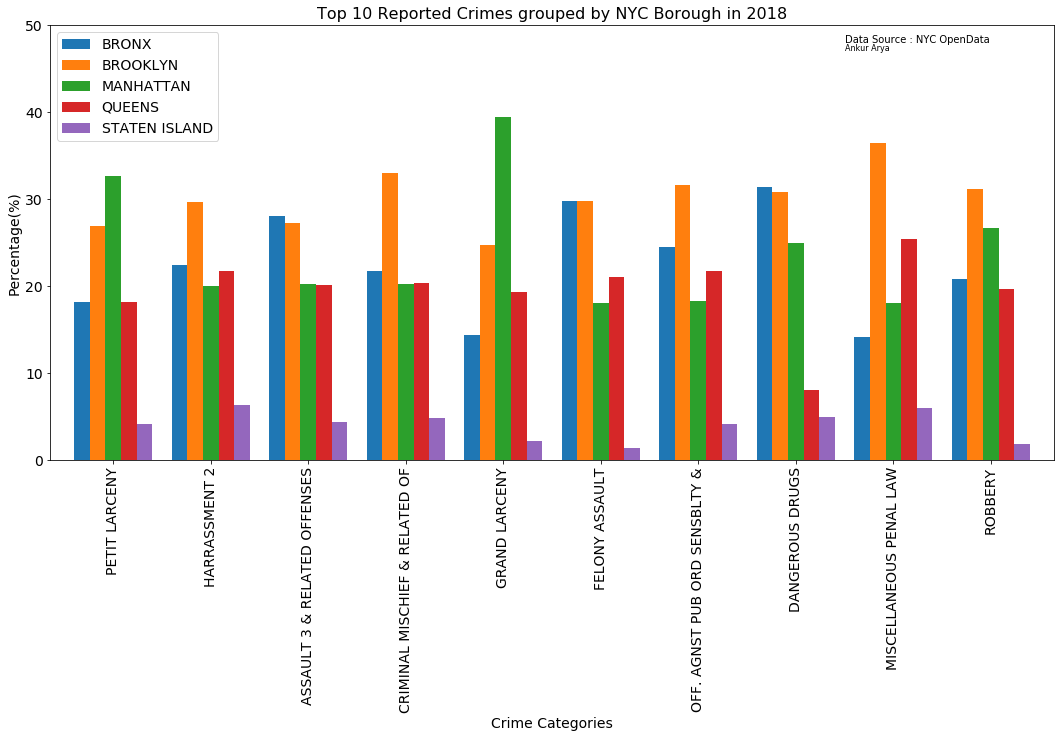

In [27]:
df_top_10_crime_sum.plot(kind='bar', figsize = (18,8), fontsize = 14, ylim = (0,50), width=0.8)
plt.ylabel('Percentage(%)',fontsize = 14)
plt.xlabel('Crime Categories',fontsize = 14,wrap=True)
plt.title('Top 10 Reported Crimes grouped by NYC Borough in 2018',fontsize = 16)
plt.annotate('Data Source : NYC OpenData', xy=(7.5,48), fontsize=10)
plt.annotate('Ankur Arya', xy=(7.5,47),fontsize=8)
plt.legend(loc='upper left', title = '', fontsize = 14)

## Create Heat Map of NYC neighborhoods based on number of crimes reported in 2018

In [28]:
# Create base map layer of NY city
copyright_st = '<a> Ankur Arya 2019</a>'\
                ' | Data Courtesy:<a href="https://opendata.cityofnewyork.us/"> NYC OpenData </a>'

map_crime = folium.Figure(width=900, height=950)
map_crime = folium.Map(location=[latitude, longitude],zoom_start=11, attr = copyright_st,tiles="Mapbox Bright").add_to(map_crime)

In [29]:
json_file =r'NYC_Neighborhood_Centroid_Derivative.geojson'
folium.Choropleth(
    geo_data = json_file,
    data = df_nta,
    columns = ['hood_name','CMPLNT_NUM'],
    key_on = 'feature.properties.hood_name',
    nan_fill_color='white',
    nan_fill_opacity=0,
    fill_opacity=0.8,
    fill_color='YlOrRd',
    bins=df_nta['CMPLNT_NUM'].quantile([0, 0.25,0.5, 0.75, 0.94,1]),
    name='Crime Reported 2018',
    highlight=False,
    legend_name='Number of Crime Reported in 2018',
    reset=True
).add_to(map_crime)

In [30]:
# Add the neighborhood centroids in the map
for index in np.arange(0,len(nycentroid_list)):
    folium.CircleMarker(
    [nycentroid_list[index][1],nycentroid_list[index][0]],
    radius=10, 
    color='',
    fill=True,
    fill_color='',
    fill_opacity=0,
    popup = df_nyhood['Name'][index]
    ).add_to(map_crime)

In [31]:
view_map(map_crime)

In [32]:
map_crime.save('nyc_crimes_heatmap.html')